In [1]:
import numpy as np                        # Math
import scipy.stats                        # Statistics
from matplotlib import pyplot as plt      # Plots

Read the npy file

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/transient.npy'
data = np.load(input_file_path)

#print(data)

This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

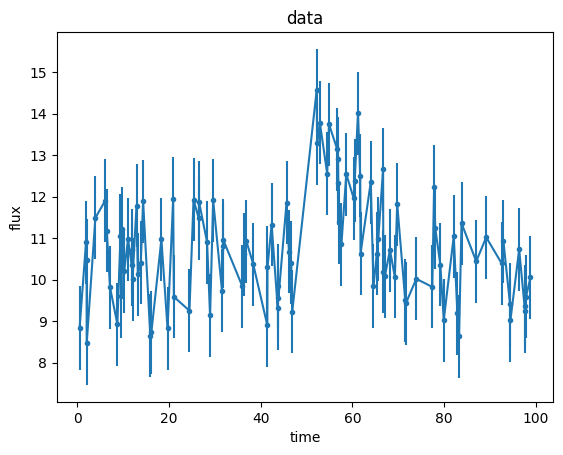

In [3]:
t,y,yerr=data.T

plt.errorbar(t,y,yerr=yerr, marker = '.')
plt.xlabel('time')
plt.ylabel('flux')
plt.title('data')

plt.show()

# Dynesty

Using the crash course: https://dynesty.readthedocs.io/en/latest/crashcourse.html

### Setup

The model

In [4]:
def burst_model (x, theta):
    A,b,t0,alpha=theta
    return np.where(x<t0,b,b+A*np.exp(-alpha*(x-t0)))

The log likelihood

In [17]:
def LogLikelihood(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst':
        y_fit = burst_model(x, theta)
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 

The log prior

In [6]:
Amin, Amax = 0, 50
bmin, bmax = 0, 50
t0min, t0max = 0, 100
alphamin, alphamax = np.exp(-5), np.exp(5)

def prior_transform(u):
    x = np.zeros(len(u))  # copy u

    x[0] = scipy.stats.uniform(loc=Amin, scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin, scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min, scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3], alphamin, alphamax)
    
    return x

The log posterior

def LogPosterior(theta, data, model):
    return LogLikelihood(theta, data, model) + Logprior(theta)

The posterior in emcee is always something proportional to the actual posterior

### Static nested sampling

In [20]:
import dynesty

ndim = 4             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim, logl_args=[data, 'burst'], nlive=200)
sampler.run_nested()
sresults = sampler.results

#NB: in dynesty.NestedSampler devo aggiungere a parte gli argomenti di loglike e ptransf che non siano x!


/var/folders/3l/57cgtgxx4wlbtdzf79pbzvx40000gn/T/ipykernel_37152/1977231980.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x<t0,b,b+A*np.exp(-alpha*(x-t0)))
/var/folders/3l/57cgtgxx4wlbtdzf79pbzvx40000gn/T/ipykernel_37152/1977231980.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(x<t0,b,b+A*np.exp(-alpha*(x-t0)))
737it [00:10, 16.79it/s, bound: 0 | nc: 30 | ncall: 7375 | eff(%):  9.993 | loglstar:   -inf < -161.161 <    inf | logz: -169.444 +/-  0.194 | dlogz: 102.005 >  0.209]     /var/folders/3l/57cgtgxx4wlbtdzf79pbzvx40000gn/T/ipykernel_37152/1977231980.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(x<t0,b,b+A*np.exp(-alpha*(x-t0)))
746it [00:10, 28.97it/s, bound: 1 | nc: 10 | ncall: 7424 | eff(%): 10.048 | loglstar:   -inf < -155.494 <    inf | logz: -163.896 +/-  0.191 | dlogz: 96.357 >  0.209] /var/folders/3l/57cgtgxx4wlbtdzf79pbzvx40000gn/T/ipykernel_37152/1977231980.py:3: RuntimeWarning: overflow encountered in 

Diagnostic plot

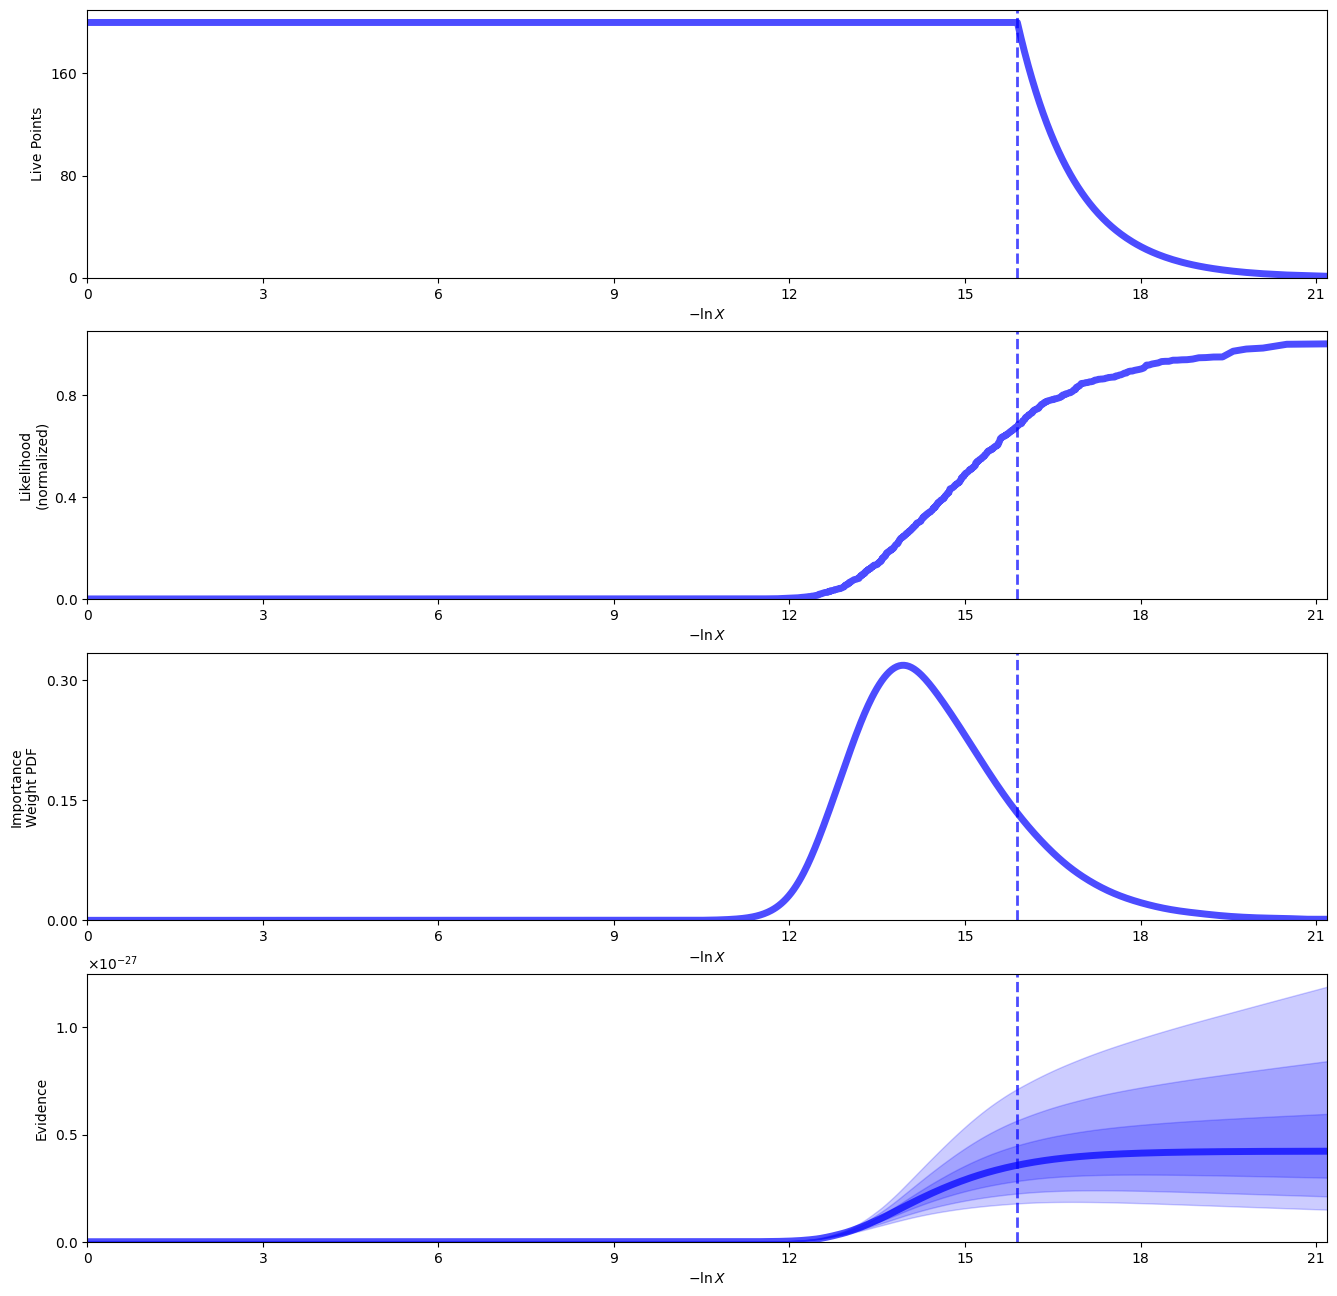

In [21]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

traceplots

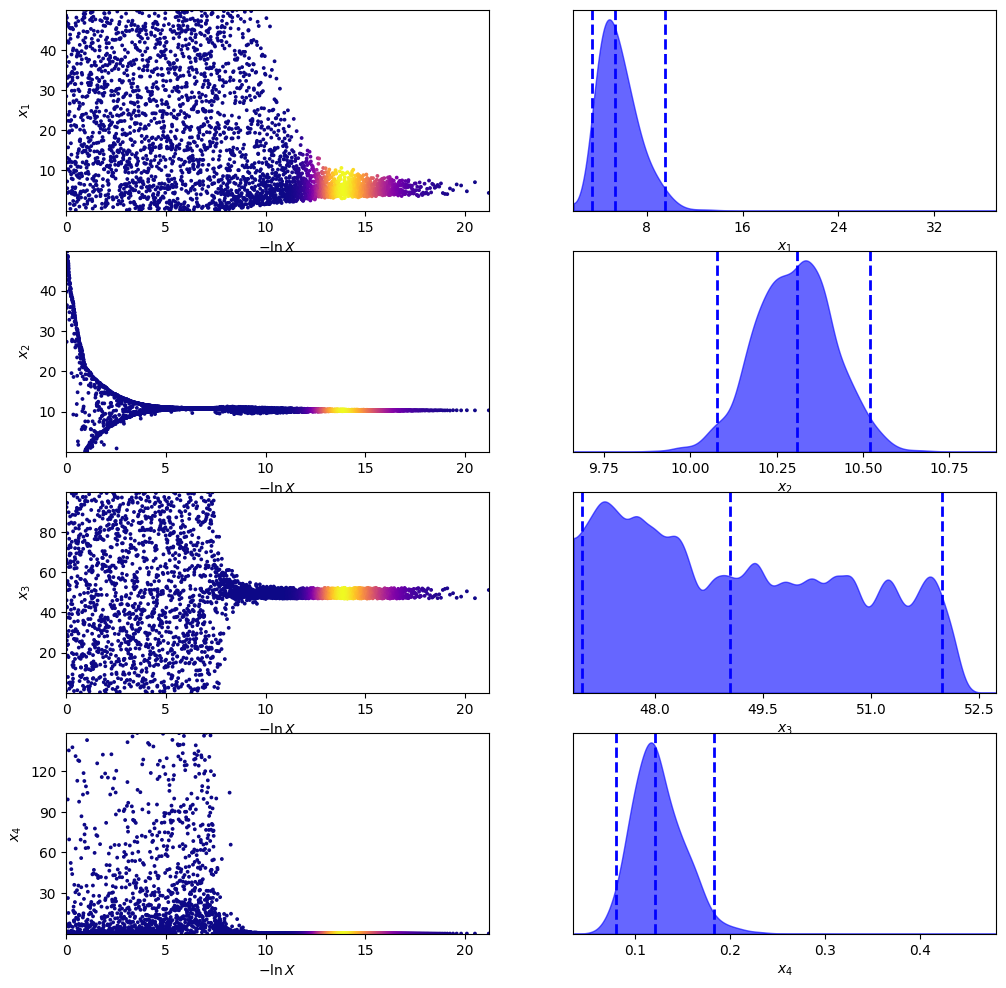

In [22]:
tfig, taxes = dyplot.traceplot(sresults)

### Corner plots

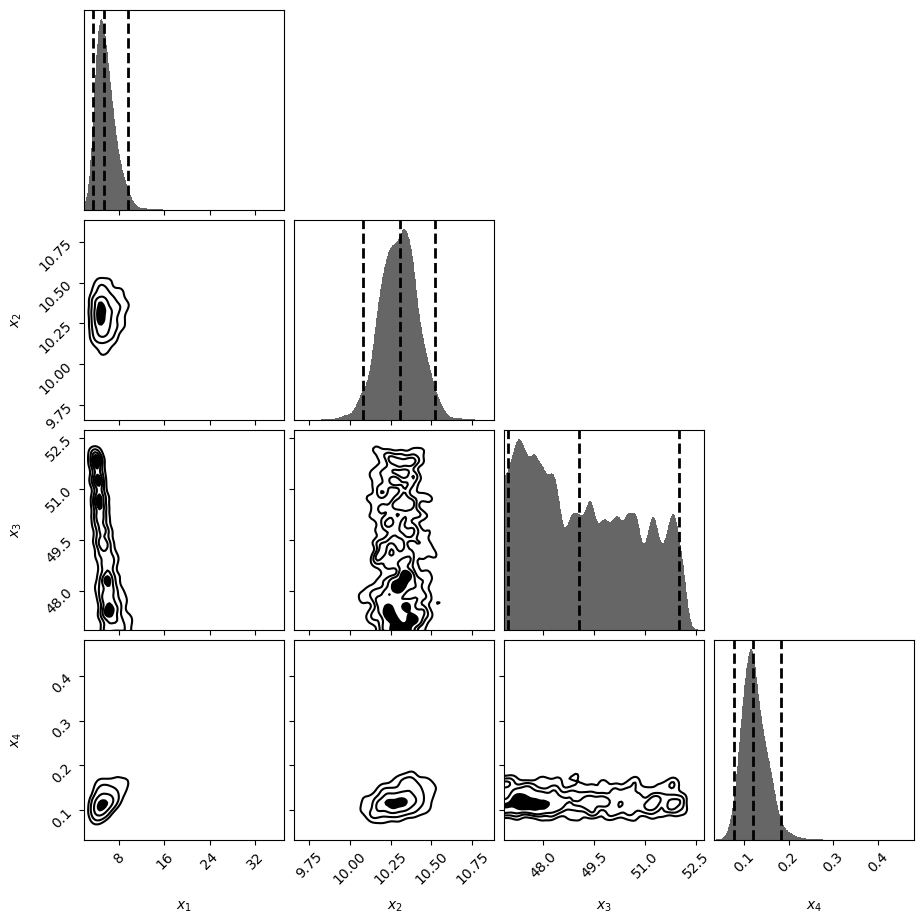

In [23]:
cfig, caxes = dyplot.cornerplot(sresults)

Median and quantiles

In [24]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 4.224739079448176e-28
68% parameter credible regions are:
 [[4.1037241031093075, 7.23899047373586], [10.192017003746285, 10.40805900547921], [47.47595104901728, 51.1364376928566], [0.09807004702710433, 0.1518727785251154]]

Mean and covariance of parameters are: [ 5.67331245 10.30200383 49.21398417  0.12473687]
[[ 2.68045272e+00  1.34143279e-02 -1.71452506e+00  2.60411067e-02]
 [ 1.34143279e-02  1.27622917e-02 -2.41223319e-03  1.20866297e-03]
 [-1.71452506e+00 -2.41223319e-03  2.41812100e+00 -1.69537715e-03]
 [ 2.60411067e-02  1.20866297e-03 -1.69537715e-03  7.38843615e-04]]


# <span style="color:red"> Finire seconda parte dell'esercizio --> profilo gaussiano </span> 